In [1]:
# This notebook illustrates handling the August 2024 Demo of the 12mo Evaluation Scenario 1

# Import funman related code
import os
from funman.api.run import Runner
from funman_demo import summarize_results
from funman import FunmanWorkRequest, EncodingSchedule 
import json
from funman.representation.constraint import LinearConstraint, ParameterConstraint, StateVariableConstraint
from funman.representation import Interval
import pandas as pd

RESOURCES = "../../resources"
SAVED_RESULTS_DIR = "./out"

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet","monthly-demo", "2024-08", "12_month_scenario_1", "q1a_ii")
MODEL_PATH = os.path.join(
    EXAMPLE_DIR, "eval_scenario1_base.json"
)
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "eval_scenario1_base_request.json"
)


request_params = {}

# %load_ext autoreload
# %autoreload 2

In [2]:
# Constants for the scenario
STATES = ["S", "I", "E", "R", "H", "D"]
# IDART = ["Diagnosed", "Infected", "Ailing", "Recognized",  "Threatened"]

MAX_TIME=10
STEP_SIZE=2
timepoints = list(range(0, MAX_TIME+STEP_SIZE, STEP_SIZE))

In [3]:
# Helper functions to setup FUNMAN for different steps of the scenario

def get_request():
    with open(REQUEST_PATH, "r") as request:
        funman_request = FunmanWorkRequest.model_validate(json.load(request))
        return funman_request

def set_timepoints(funman_request, timepoints):
    funman_request.structure_parameters[0].schedules = [EncodingSchedule(timepoints=timepoints)]

def unset_all_labels(funman_request):
    for p in funman_request.parameters:
        p.label = "any"
    
def set_config_options(funman_request, debug=False, dreal_precision=1e-1):
    # Overrides for configuration
    #
    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    # funman_request.config.use_compartmental_constraints=False
    if debug:
        funman_request.config.save_smtlib="./out"
    funman_request.config.tolerance = 0.01
    funman_request.config.dreal_precision = dreal_precision
    # funman_request.config.verbosity = 10
    # funman_request.config.dreal_log_level = "debug"
    # funman_request.config.dreal_prefer_parameters = ["beta","NPI_mult","r_Sv","r_EI","r_IH_u","r_IH_v","r_HR","r_HD","r_IR_u","r_IR_v"]

def get_synthesized_vars(funman_request):
    return [p.name for p in funman_request.parameters if p.label == "all"]

def run(funman_request, plot=False):
    to_synthesize = get_synthesized_vars(funman_request)
    return Runner().run(
        MODEL_PATH,
        funman_request,
        description="SIERHD Eval 12mo Scenario 1 q1",
        case_out_dir=SAVED_RESULTS_DIR,
        dump_plot=plot,
        print_last_time=True,
        parameters_to_plot=to_synthesize
    )

def setup_common(funman_request, synthesize=False, debug=False, dreal_precision=1e-1):
    set_timepoints(funman_request, timepoints)
    if not synthesize:
        unset_all_labels(funman_request)
    set_config_options(funman_request, debug=debug, dreal_precision=dreal_precision)
    

def set_compartment_bounds(funman_request, upper_bound=9830000.0, error=0.01):
    # Add bounds to compartments
    for var in STATES:
        funman_request.constraints.append(StateVariableConstraint(name=f"{var}_bounds", variable=var, interval=Interval(lb=0, ub=upper_bound, closed_upper_bound=True),soft=False))

    # Add sum of compartments
    funman_request.constraints.append(LinearConstraint(name=f"compartment_bounds", variables=STATES, additive_bounds=Interval(lb=upper_bound-error, ub=upper_bound+error, closed_upper_bound=False), soft=True))

def relax_parameter_bounds(funman_request, factor = 0.1):
    # Relax parameter bounds
    parameters = funman_request.parameters
    for p in parameters:
        interval = p.interval
        width = float(interval.width())
        interval.lb = interval.lb - (factor/2 * width)
        interval.ub = interval.ub + (factor/2 * width)

def plot_last_point(results):
    pts = results.parameter_space.points() 
    print(f"{len(pts)} points")

    if len(pts) > 0:
        # Get a plot for last point
        df = results.dataframe(points=pts[-1:])
        ax = df[STATES].plot()
        ax.set_yscale("log")

def get_last_point_parameters(results):
    pts = results.parameter_space.points()
    if len(pts) > 0:
        pt = pts[-1]
        parameters = results.model._parameter_names()
        param_values = {k:v for k, v in pt.values.items() if k in parameters }
        return param_values

def pretty_print_request_params(params):
    # print(json.dump(params, indent=4))
    if len(params)>0:

        df = pd.DataFrame(params)
        print(df.T)


def report(results, name):
    plot_last_point(results)
    param_values = get_last_point_parameters(results)
    # print(f"Point parameters: {param_values}")
    if param_values is not None:
        request_params[name] = param_values
    pretty_print_request_params(request_params)

def add_unit_test(funman_request):
    pass
    # funman_request.constraints.append(LinearConstraint(name="unit_test", variables = [
    #         "Infected",
    #         "Diagnosed",
    #         "Ailing",
    #         "Recognized",
    #         "Threatened"
    #      ],
    #      additive_bounds= {
    #         "lb": 0.55,
    #         "ub": 0.65
    #      },
    #      timepoints={
    #         "lb": 45,
    #         "ub": 55
    #      }
    #   ))


In [4]:
# Find a single parameterization of the model where sum(IDART) is approx 60% around day 47.

funman_request = get_request()
setup_common(funman_request, debug=True, dreal_precision=1e0)
add_unit_test(funman_request)
results = run(funman_request)
# report(results, "unconstrained")

[19340000.00000, 19340000.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.40000, 0.40000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.20000, 0.20000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.80000, 0.80000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.07000, 0.07000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.20000, 0.20000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.10000, 0.10000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.88000, 0.88000) has equal lower and upper bounds, so assuming the 

In [5]:
results
# get_last_point_parameters(results)
# plot_last_point(results)
# def plot_last_point(results):
#     pts = results.parameter_space.points() 
#     print(f"{len(pts)} points")

#     if len(pts) > 0:
#         # Get a plot for last point
#         df = results.dataframe(points=pts[-1:])
#         ax = df[STATES].plot()
#         ax.set_yscale("log")
pts = results.parameter_space.points() 
print(f"{len(pts)} points")
df = results.dataframe(points=pts[-1:])

df

1 points


/home/danbryce/funman/src/funman/server/query.py:384: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.infer_objects(copy=False).interpolate(


,D,E,H,I,R,S,id,label,p_H_to,p_I_to,r_E_to,r_H_to,r_I_to
time,,,,,,,,,,,,,
0.0,0.000000,1.000000,0.000000,4.000000,0.000000,1.934000e+07,0,true,None,None,None,None,None
1.0,0.000000,2.400000,0.080000,3.896000,0.224000,1.933999e+07,0,true,None,None,None,None,None
2.0,0.000000,3.799999,0.160000,3.792000,0.448000,1.933999e+07,0,true,None,None,None,None,None
3.0,0.001920,4.556799,0.219840,4.263808,0.674432,1.933999e+07,0,true,None,None,None,None,None
4.0,0.003840,5.313598,0.279680,4.735616,0.900864,1.933999e+07,0,true,None,None,None,None,None
5.0,0.007196,6.145124,0.346424,5.438429,1.190670,1.933999e+07,0,true,None,None,None,None,None
6.0,0.010552,6.976649,0.413169,6.141241,1.480477,1.933998e+07,0,true,None,None,None,None,None
7.0,0.015510,8.037814,0.494677,7.069837,1.860745,1.933998e+07,0,true,None,None,None,None,None
8.0,0.020468,9.098979,0.576185,7.998432,2.241013,1.933998e+07,0,true,None,None,None,None,None


In [6]:
import matplotlib.pyplot as plt

# plt.plot(df.Infected)


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"a": [0, 1], "b": [3, 4]})
l = list(df.a.values)
# l = [float(v) for v in l]
type(l[0])

# p = plt.plot(df.a, df.b)
df
# print(p)
# plt.plot(l)

# plt.plot(df.a.values)
# plt.plot(df['a'])
# df.plot()

,a,b
0,0,3
1,1,4


In [8]:
# Add bounds [0, N] to the STATE compartments.  
# Add bounds sum(STATE) in [N-e, N+e], for a small e.

funman_request = get_request()
setup_common(funman_request, debug=True)
set_compartment_bounds(funman_request)
results = run(funman_request)
report(results, "compartmental_constrained")

2024-08-16 18:16:59,767 - funman.server.worker - INFO - FunmanWorker running...
2024-08-16 18:16:59,769 - funman.server.worker - INFO - Starting work on: 7692d692-8ab5-4a84-9e25-f0b2e01c1187
[19340000.00000, 19340000.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.40000, 0.40000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.20000, 0.20000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.80000, 0.80000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.07000, 0.07000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.20000, 0.20000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.10000,

0 points


In [9]:
# Relax the bounds on the parameters to allow additional parameterizations

funman_request = get_request()
setup_common(funman_request)
set_compartment_bounds(funman_request)
relax_parameter_bounds(funman_request, factor = 0.75)
results = run(funman_request)
report(results, "relaxed_bounds")

2024-08-16 18:17:01,990 - funman.server.worker - INFO - FunmanWorker running...
2024-08-16 18:17:01,993 - funman.server.worker - INFO - Starting work on: 9756fa28-57d3-4d09-a095-ce13262126d4
[19340000.00000, 19340000.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.40000, 0.40000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.20000, 0.20000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.80000, 0.80000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.07000, 0.07000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.20000, 0.20000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.10000,

0 points


In [10]:
funman_request = get_request()
setup_common(funman_request, synthesize=True)
set_compartment_bounds(funman_request)
# relax_parameter_bounds(funman_request, factor=0.75)
# funman_request.config.verbosity=10
results = run(funman_request, plot=True)
report(results, "synthesis")

2024-08-16 18:17:04,177 - funman.server.worker - INFO - FunmanWorker running...
2024-08-16 18:17:04,179 - funman.server.worker - INFO - Starting work on: 32faba99-2ef3-40a1-ad37-59ed7d39e7e9
[19340000.00000, 19340000.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.40000, 0.40000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.20000, 0.20000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.80000, 0.80000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.07000, 0.07000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.20000, 0.20000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.10000,

0 points


In [11]:
# import pandas as pd
# df1 = pd.DataFrame({"ltp": ltp, "gtp": gtp})

# # df2 = 
# # df1.ltp.N == df1.gtp.N
# # df2.loc[df2].sort_index()[0:60]

# #(= H_10 (+ H_8 (* 2 (+ (* r_HD (- 1) H_8) (* r_HR (- 1) H_8) (* r_IH_v I_v_8) (* r_IH_u I_u_8)))))

# df1['same'] = df1['ltp'] == df1["gtp"]
# df1[0:20]
# # df1.loc[df1.index.str.endswith("_6")].sort_values(by="same")

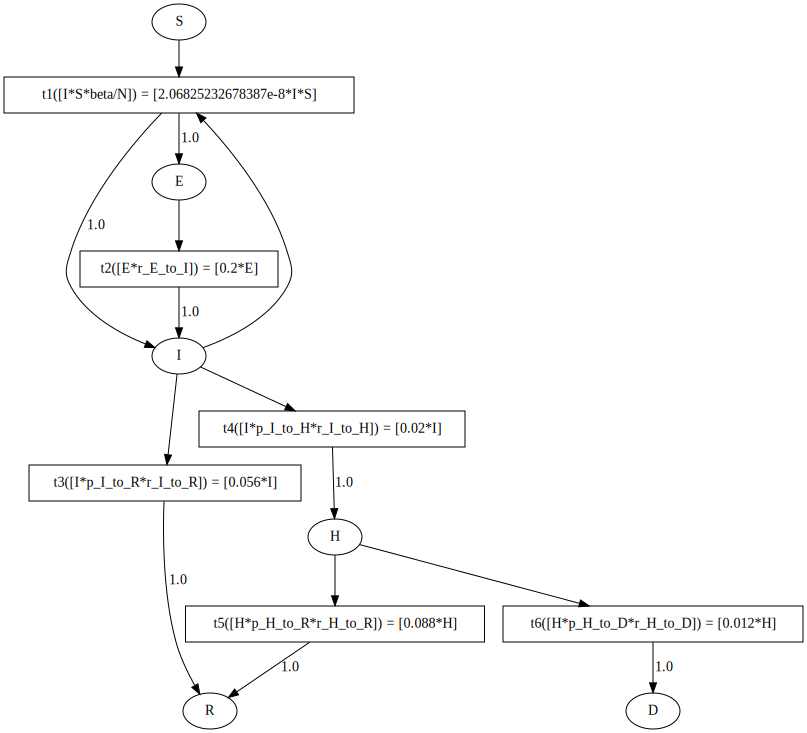

In [12]:
# # Get points (trajectories generated)
# pts = results.parameter_space.points() 
# print(f"{len(pts)} points")

# # Get a plot for last point
# df = results.dataframe(points=pts[-1:])
# ax = df[STATES].plot()
# ax.set_yscale("log")


# # Get the values of the point
# gtp=pts[-1].values


# # Output the model diagram
# #
results.model.to_dot()
# # gtp